In [1]:
import pandas as pd #the csv reading library
import matplotlib.pyplot as plt #the ploting library
import glob #to get file names
import numpy as np
from pandas import Series
import seaborn as sns
from matplotlib.pyplot import figure
import cmocean.cm as cmo
import seaborn as sns

from pylab import rcParams
from numpy import diff
from scipy import interpolate
import scipy.stats as stats
from scipy.interpolate import CubicSpline


from scipy.signal import savgol_filter
from sklearn.linear_model import LinearRegression

import statsmodels.api as sm
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

import matplotlib.gridspec as gridspec
from IPython.display import display, Math
from sklearn.metrics import r2_score

from statistics import mean, median
from pylr2 import regress2


In [27]:
mds_spectra_pw = pd.read_csv('../Cruise_2024/Data/MSD_sprectra_pchip_baseline_corrected_PW.csv',sep=',', index_col=0)
mds_spectra_rz = pd.read_csv('../Cruise_2024/Data/MSD_sprectra_pchip_baseline_corrected_RZ.csv',sep=',', index_col=0)

mds_spectra_pw.columns = ['a' + col for col in mds_spectra_pw.columns]
mds_spectra_rz.columns = ['a' + col for col in mds_spectra_rz.columns]

mds_spectra_pw = mds_spectra_pw.drop(241501)


mds_fe2_rz = pd.read_csv('../Cruise_2024/Data/FeT_RZ.csv', sep=',', index_col=0)
mds_fet_rz = pd.read_csv('../Cruise_2024/Data/Fe2_RZ.csv', sep=',', index_col=0)

mds_toc = pd.read_csv('../Cruise_2024/Data/TOC_MDS_Depths.csv', sep=',', index_col=0)
mds_toc_join = mds_toc['NPOC_uM']
mds_toc_joinLocation = mds_toc['Location']


mds_fe_rz = mds_fe2_rz.join(mds_fet_rz)
mds_fe_rz['Fe3_uM'] = mds_fe_rz['FeT_uM'] - mds_fe_rz['Fe2_uM']
mds_fe_rz.loc[mds_fe_rz['Fe3_uM'] < 0, 'Fe3_uM'] = np.nan


mds_fe_pw = pd.read_csv('../Cruise_2024/Data/PW_MSD_24.csv', sep=',', index_col=0)
mds_fe_pw['FeT_uM'] = mds_fe_pw['FeT_um'] 
mds_fe_pw['Fe2_uM'] = mds_fe_pw['Fe2'] 
mds_fe_pw['Fe3_uM'] = mds_fe_pw['Fe3'] 
mds_fe_pw.loc[mds_fe_pw['Fe3_uM'] < 0, 'Fe3_uM'] = np.nan


mds_fe_pw = mds_fe_pw[['FeT_uM', 'Fe2_uM', 'Fe3_uM']]
mds_fe_rz = mds_fe_rz[['FeT_uM', 'Fe2_uM', 'Fe3_uM']]


mds_spectra_pw_join = mds_spectra_pw

mds_pw = mds_fe_pw.join(mds_toc)
#mds_pw = mds_pw.join(mds_toc_joinLocation)
mds_pw = mds_pw.join(mds_spectra_pw_join)

mds_spectra_rz_join = mds_spectra_rz

mds_rz = mds_fe_rz.join(mds_toc)
#mds_rz = mds_rz.join(mds_toc_joinLocation)
mds_rz = mds_rz.join(mds_spectra_rz_join)

mds_rz['Type'] = 'Rhz'
mds_pw['Type'] = 'Cent'


mds_rz['SUVA'] = mds_rz['a254'] / (mds_rz['NPOC_uM'] * 0.012) 
mds_rz['SUVA_350'] = mds_rz['a350'] / (mds_rz['NPOC_uM'] * 0.012) 

mds_pw['SUVA'] = mds_pw['a254'] / (mds_pw['NPOC_uM'] * 0.012) 
mds_pw['SUVA_350'] = mds_pw['a350'] / (mds_pw['NPOC_uM'] * 0.012) 

mds_rz['Depth'] = pd.to_numeric(mds_rz['Depth'], errors='coerce')
mds_rz = mds_rz.sort_values(by='Depth')

#mds_pw = mds_pw[['Fe3_uM', 'a350', 'Type', 'NPOC_uM']]
mds_rz['NPOC_uM'] = mds_rz['NPOC_uM'].where(mds_rz['NPOC_uM'] <= 3000, np.nan)
mds_pw['NPOC_uM'] = mds_pw['NPOC_uM'].where(mds_pw['NPOC_uM'] <= 3000, np.nan)

#mds_rz['NPOC_uM'].max()

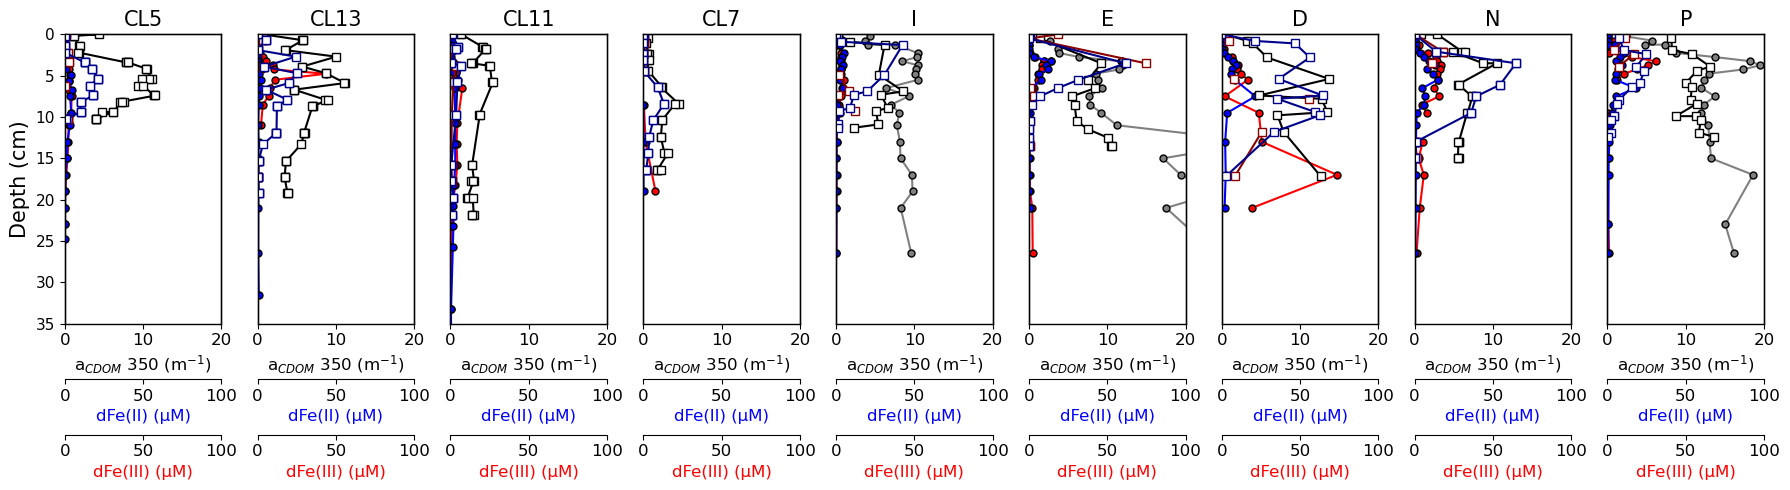

In [3]:
stns = ['CL5', 'CL13', 'CL11', 'CL7', 'I', 'E', 'D', 'N', 'P']

fig, axes = plt.subplots(1, len(stns), figsize=(len(stns)*2, 5))

for i, stn in enumerate(stns):
    ax = axes[i]

    dsc = mds_pw
    dsr = mds_rz

    dsc = dsc[dsc['Location']  == stns[i]]
    #dsc['Depth'] = pd.to_numeric(dsc['Depth'], errors='coerce')
    dsc = dsc[dsc['Depth'] >= 0]

    dsr = dsr[dsr['Location']  == stns[i]]
    #dsr['Depth'] = pd.to_numeric(dsr['Depth'], errors='coerce')
    dsr = dsr[dsr['Depth'] >= 0]
    
    
    SUVA_pw = dsc['SUVA'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    a350_pw = dsc['a350'] 
    a350_pw = np.asarray(a350_pw, dtype=float).ravel()
    fe_pw = dsc['Fe3_uM'] 
    fe_pw = np.asarray(fe_pw, dtype=float).ravel()
    fe2_pw = dsc['Fe2_uM'] 
    fe2_pw = np.asarray(fe2_pw, dtype=float).ravel()
    depth_pw = dsc['Depth'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['SUVA'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    a350_rz = dsr['a350'] 
    a350_rz = np.asarray(a350_rz, dtype=float).ravel()
    fe_rz = dsr['Fe3_uM'] 
    fe_rz = np.asarray(fe_rz, dtype=float).ravel()
    fe2_rz = dsr['Fe2_uM'] 
    fe2_rz = np.asarray(fe2_rz, dtype=float).ravel()
    depth_rz = dsr['Depth']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    s = 12

    ax.plot(a350_pw, depth_pw, c = 'grey', lw = 1.5,  marker = 'o', markersize = 5, markeredgecolor='black')
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(35, 0)
    ax.set_xlim(0, 20)

    ax1 = ax.twiny()
    ax1.plot(fe_pw, depth_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='black')
    ax1.set_xlim(0, 100)
    
    ax4 = ax.twiny()
    ax4.plot(fe2_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='black')
    ax4.set_xlim(0, 100)

    ax3 = ax.twiny()
    ax3.plot(a350_rz, depth_rz, c = 'black', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='black')
    ax3.set_xlim(0, 20)

    ax2 = ax.twiny()
    ax2.plot(fe_rz, depth_rz, c = 'darkred', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkred')
    ax2.set_xlim(0, 100)

    ax5 = ax.twiny()
    ax5.plot(fe2_rz, depth_rz, c = 'darkblue', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkblue')
    ax5.set_xlim(0, 100)

    ax.set_ylabel('Depth (cm)', size=15, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    #ax.set_xlabel('aCDOM 350 (m$^{-1}$ mgL$^{-1}$)', size=s, c='black')
    ax.set_xlabel('a$_{CDOM}$ 350 (m$^{-1}$)', size=s, c='black')
    ax.xaxis.set_tick_params(labelsize=s)

    ax1.set_xlabel('dFe(II) (µM)', size = s, c= 'b')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 40))
    ax1.xaxis.set_tick_params(labelsize=s)

    ax2.set_xlabel('dFe(III) (µM)', size = s, c= 'r')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 80))
    ax2.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('')
    ax3.xaxis.set_ticklabels([])
    ax3.set_xticks([])

    ax4.set_xlabel('')
    ax4.xaxis.set_ticklabels([])
    ax4.set_xticks([])

    ax5.set_xlabel('')
    ax5.xaxis.set_ticklabels([])
    ax5.set_xticks([])

    
    if i == 0:
        axes[0].set_ylabel('Depth (cm)', size=15, c='black')
        axes[0].yaxis.set_tick_params(labelsize=11)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')

plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_MDS.png')
plt.show()

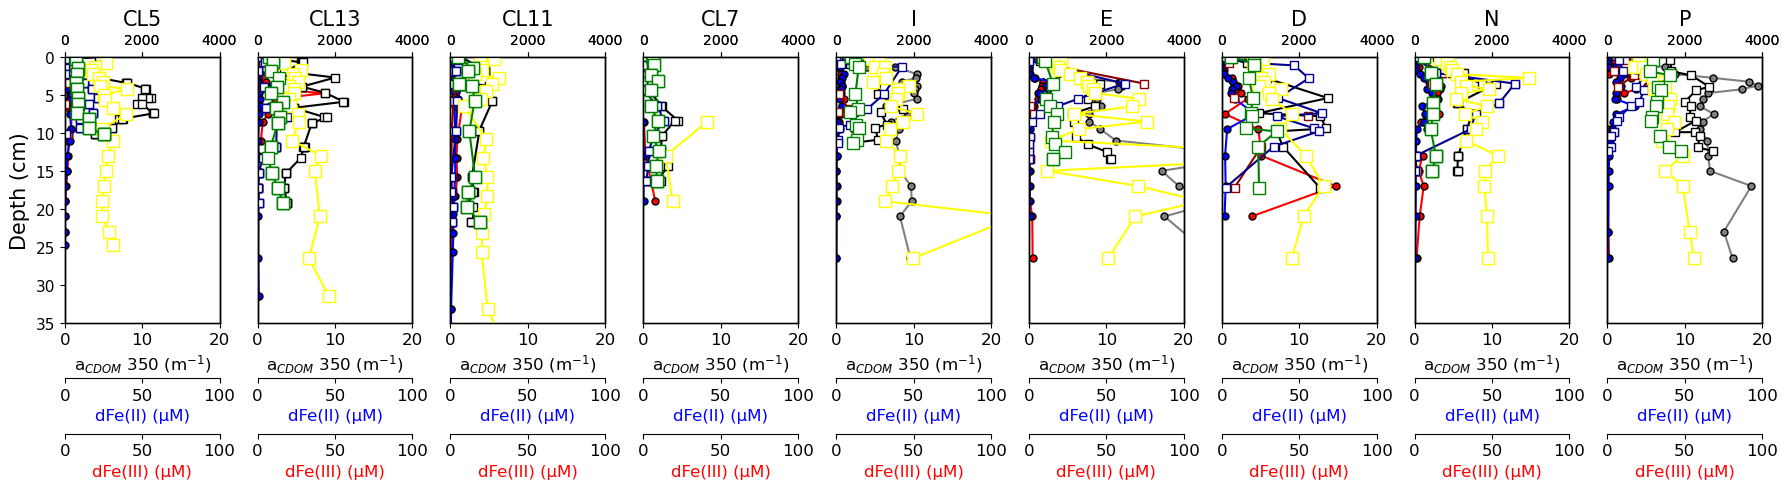

In [26]:
stns = ['CL5', 'CL13', 'CL11', 'CL7', 'I', 'E', 'D', 'N', 'P']

fig, axes = plt.subplots(1, len(stns), figsize=(len(stns)*2, 5))

for i, stn in enumerate(stns):
    ax = axes[i]

    dsc = mds_pw
    dsr = mds_rz

    dsc = dsc[dsc['Location']  == stns[i]]
    #dsc['Depth'] = pd.to_numeric(dsc['Depth'], errors='coerce')
    dsc = dsc[dsc['Depth'] >= 0]

    dsr = dsr[dsr['Location']  == stns[i]]
    #dsr['Depth'] = pd.to_numeric(dsr['Depth'], errors='coerce')
    dsr = dsr[dsr['Depth'] >= 0]
    
    
    SUVA_pw = dsc['NPOC_uM'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    a350_pw = dsc['a350'] 
    a350_pw = np.asarray(a350_pw, dtype=float).ravel()
    fe_pw = dsc['Fe3_uM'] 
    fe_pw = np.asarray(fe_pw, dtype=float).ravel()
    fe2_pw = dsc['Fe2_uM'] 
    fe2_pw = np.asarray(fe2_pw, dtype=float).ravel()
    depth_pw = dsc['Depth'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['NPOC_uM'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    a350_rz = dsr['a350'] 
    a350_rz = np.asarray(a350_rz, dtype=float).ravel()
    fe_rz = dsr['Fe3_uM'] 
    fe_rz = np.asarray(fe_rz, dtype=float).ravel()
    fe2_rz = dsr['Fe2_uM'] 
    fe2_rz = np.asarray(fe2_rz, dtype=float).ravel()
    depth_rz = dsr['Depth']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    s = 12

    ax.plot(a350_pw, depth_pw, c = 'grey', lw = 1.5,  marker = 'o', markersize = 5, markeredgecolor='black')
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(35, 0)
    ax.set_xlim(0, 20)

    ax1 = ax.twiny()
    ax1.plot(fe_pw, depth_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='black')
    ax1.set_xlim(0, 100)
    
    ax4 = ax.twiny()
    ax4.plot(fe2_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='black')
    ax4.set_xlim(0, 100)

    ax3 = ax.twiny()
    ax3.plot(a350_rz, depth_rz, c = 'black', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='black')
    ax3.set_xlim(0, 20)

    ax2 = ax.twiny()
    ax2.plot(fe_rz, depth_rz, c = 'darkred', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkred')
    ax2.set_xlim(0, 100)

    ax5 = ax.twiny()
    ax5.plot(fe2_rz, depth_rz, c = 'darkblue', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkblue')
    ax5.set_xlim(0, 100)

    ax6 = ax.twiny()
    ax6.plot(SUVA_pw, depth_pw, c = 'yellow', lw = 1.5,  marker='s', markersize = 9, markerfacecolor='white', markeredgecolor='yellow')
    ax6.set_xlim(0, 4000)

    ax7 = ax.twiny()
    ax7.plot(SUVA_rz, depth_rz, c = 'green', lw = 1.5,  marker='s', markersize = 9, markerfacecolor='white', markeredgecolor='green')
    ax7.set_xlim(0, 4000)

    ax.set_ylabel('Depth (cm)', size=15, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    #ax.set_xlabel('aCDOM 350 (m$^{-1}$ mgL$^{-1}$)', size=s, c='black')
    ax.set_xlabel('a$_{CDOM}$ 350 (m$^{-1}$)', size=s, c='black')
    ax.xaxis.set_tick_params(labelsize=s)

    ax1.set_xlabel('dFe(II) (µM)', size = s, c= 'b')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 40))
    ax1.xaxis.set_tick_params(labelsize=s)

    ax2.set_xlabel('dFe(III) (µM)', size = s, c= 'r')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 80))
    ax2.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('')
    ax3.xaxis.set_ticklabels([])
    ax3.set_xticks([])

    ax4.set_xlabel('')
    ax4.xaxis.set_ticklabels([])
    ax4.set_xticks([])

    ax5.set_xlabel('')
    ax5.xaxis.set_ticklabels([])
    ax5.set_xticks([])

    
    if i == 0:
        axes[0].set_ylabel('Depth (cm)', size=15, c='black')
        axes[0].yaxis.set_tick_params(labelsize=11)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')

plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_MDS.png')
plt.show()

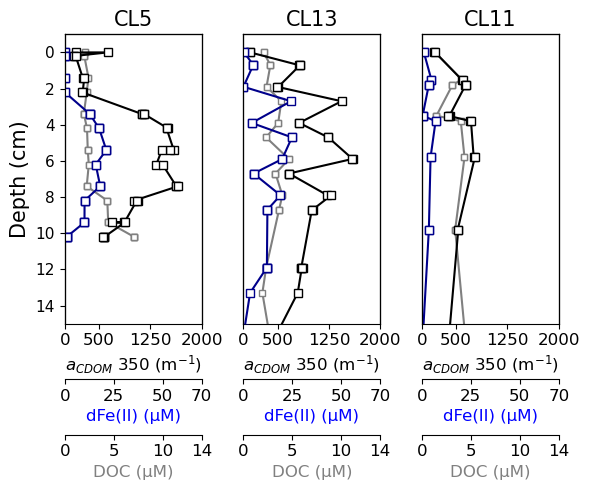

In [30]:
#stns = ['CL5', 'CL13', 'CL11']
#stns = ['CL7', 'D', 'N']
stns = [ 'I', 'E',  'P']

fig, axes = plt.subplots(1, len(stns), figsize=(len(stns)*2, 5))

for i, stn in enumerate(stns):
    ax = axes[i]

    dsc = mds_pw
    dsr = mds_rz

    dsc = dsc[dsc['Location']  == stns[i]]
    #dsc['Depth'] = pd.to_numeric(dsc['Depth'], errors='coerce')
    dsc = dsc[dsc['Depth'] >= 0]

    dsr = dsr[dsr['Location']  == stns[i]]
    #dsr['Depth'] = pd.to_numeric(dsr['Depth'], errors='coerce')
    dsr = dsr[dsr['Depth'] >= 0]
    
    
    SUVA_pw = dsc['NPOC_uM'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    a350_pw = dsc['a350'] 
    a350_pw = np.asarray(a350_pw, dtype=float).ravel()
    fe_pw = dsc['Fe3_uM'] 
    fe_pw = np.asarray(fe_pw, dtype=float).ravel()
    fe2_pw = dsc['Fe2_uM'] 
    fe2_pw = np.asarray(fe2_pw, dtype=float).ravel()
    depth_pw = dsc['Depth'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['NPOC_uM'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    a350_rz = dsr['a350'] 
    a350_rz = np.asarray(a350_rz, dtype=float).ravel()
    fe_rz = dsr['Fe3_uM'] 
    fe_rz = np.asarray(fe_rz, dtype=float).ravel()
    fe2_rz = dsr['Fe2_uM'] 
    fe2_rz = np.asarray(fe2_rz, dtype=float).ravel()
    depth_rz = dsr['Depth']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    s = 12

    ax.plot(SUVA_rz, depth_rz, c = 'grey', lw = 1.5,  marker = 's', markersize = 5, markerfacecolor='white', markeredgecolor='grey')
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(15, -1)
    ax.set_xlim(0, 2000)
    ax.set_xticks([0, 500, 1250, 2000])

    #ax1 = ax.twiny()
    #ax1.plot(fe_pw, depth_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='black')
    #ax1.set_xlim(0, 100)
    
    #ax4 = ax.twiny()
    #ax4.plot(fe2_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='black')
    #ax4.set_xlim(0, 100)

    ax3 = ax.twiny()
    ax3.plot(a350_rz, depth_rz, c = 'black', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='black')
    ax3.set_xlim(0, 14)
    ax3.set_xticks([0, 5, 10, 14])


    #ax2 = ax.twiny()
    #ax2.plot(fe_rz, depth_rz, c = 'darkred', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkred')
    #ax2.set_xlim(0, 100)

    ax5 = ax.twiny()
    ax5.plot(fe2_rz, depth_rz, c = 'darkblue', lw = 1.5,  marker='s', markersize = 6, markerfacecolor='white', markeredgecolor='darkblue')
    ax5.set_xlim(0, 70)
    ax5.set_xticks([0, 25, 50, 70])

    ax.set_ylabel('Depth (cm)', size=15, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    #ax.set_xlabel('aCDOM 350 (m$^{-1}$ mgL$^{-1}$)', size=s, c='black')
    ax.set_xlabel(r'$a_{CDOM}$ 350 (m$^{-1}$)', size=s, c='black')
    ax.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('DOC (µM)', size = s, c= 'grey')
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 80))
    ax3.xaxis.set_tick_params(labelsize=s)

    ax5.set_xlabel('dFe(II) (µM)', size = s, c= 'b')
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 40))
    ax5.xaxis.set_tick_params(labelsize=s)
    
    if i == 0:
        axes[0].set_ylabel('Depth (cm)', size=15, c='black')
        axes[0].yaxis.set_tick_params(labelsize=11)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')

plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_MDS.png')
plt.show()

C:\Users\hmlbr\AppData\Local\Temp\ipykernel_13028\192274270.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsc['Depth'] = pd.to_numeric(dsc['Depth'], errors='coerce')
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_13028\192274270.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dsr['Depth'] = pd.to_numeric(dsr['Depth'], errors='coerce')
C:\Users\hmlbr\AppData\Local\Temp\ipykernel_13028\192274270.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

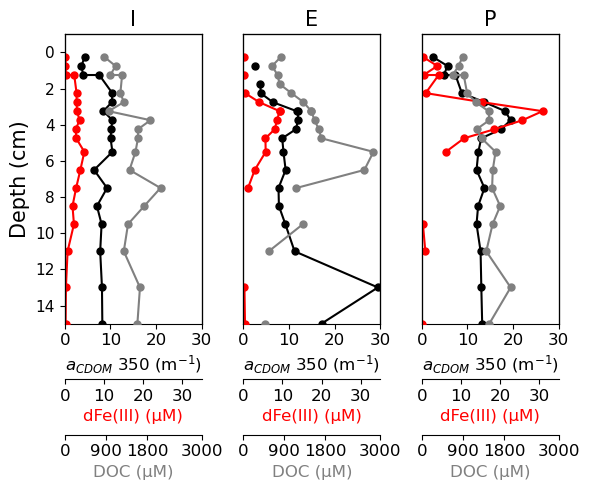

In [28]:
stns = [ 'I', 'E',  'P']

fig, axes = plt.subplots(1, len(stns), figsize=(len(stns)*2, 5))

for i, stn in enumerate(stns):
    ax = axes[i]

    dsc = mds_pw
    dsr = mds_rz

    dsc = dsc[dsc['Location']  == stns[i]]
    dsc['Depth'] = pd.to_numeric(dsc['Depth'], errors='coerce')
    dsc = dsc[dsc['Depth'] >= 0]

    dsr = dsr[dsr['Location']  == stns[i]]
    dsr['Depth'] = pd.to_numeric(dsr['Depth'], errors='coerce')
    dsr = dsr[dsr['Depth'] >= 0]
    
    
    SUVA_pw = dsc['NPOC_uM'] 
    SUVA_pw = np.asarray(SUVA_pw, dtype=float).ravel()
    a350_pw = dsc['a350'] 
    a350_pw = np.asarray(a350_pw, dtype=float).ravel()
    fe_pw = dsc['Fe3_uM'] 
    fe_pw = np.asarray(fe_pw, dtype=float).ravel()
    depth_pw = dsc['Depth'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    SUVA_rz = dsr['NPOC_uM'] 
    SUVA_rz = np.asarray(SUVA_rz, dtype=float).ravel()
    fe_rz = dsr['Fe3_uM'] 
    fe_rz = np.asarray(fe_rz, dtype=float).ravel()
    depth_rz = dsr['Depth']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    s = 12

    ax.plot(a350_pw, depth_pw, c = 'black', lw = 1.5,  marker = 'o', markersize = 5, markeredgecolor='black')
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(15, -1)
    ax.set_xlim(0, 30)
    ax.set_xticks([0, 10, 20, 30])

    ax1 = ax.twiny()
    ax1.plot(fe_pw, depth_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='red')
    ax1.set_xlim(0, 35)
    ax1.set_xticks([0, 10, 20, 30])

    ax2 = ax.twiny()
    ax2.plot(SUVA_pw, depth_pw, c = 'grey', lw = 1.5,  marker = 'o', markersize = 5,  markeredgecolor='grey')
    ax2.set_xlim(0, 3000)
    ax2.set_xticks([0, 900, 1800, 3000])
    
    ax.set_ylabel('Depth (cm)', size=15, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel(r'$a_{CDOM}$ 350 (m$^{-1}$)', size=s, c='black')
    ax.xaxis.set_tick_params(labelsize=s)

    ax1.set_xlabel('dFe(III) (µM)', size = s, c= 'r')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 40))
    ax1.xaxis.set_tick_params(labelsize=s)

    ax2.set_xlabel('DOC (µM)', size = s, c= 'grey')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 80))
    ax2.xaxis.set_tick_params(labelsize=s)

    
    if i == 0:
        axes[0].set_ylabel('Depth (cm)', size=15, c='black')
        axes[0].yaxis.set_tick_params(labelsize=11)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])
        axes[1].set_ylabel('')
        axes[2].set_ylabel('')

    axes[1].set_ylabel('')
    axes[2].set_ylabel('')

plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Poxy_paper_figs/Profiles_SUVA_MDS.png')
plt.show()

files = glob.glob('../Cruise_2024/Data/Profiles_EIP/*MDS*.csv')

def GET_DATA(name):
    df = pd.read_csv(name, sep=',', index_col=0)
    df = pd.DataFrame(df)
    return df

frames = []
for f in files:
    df = GET_DATA(f) # runs the processing function  
    frames.append(df) # adds the new col from each scan to a part of frames 
df = pd.concat(frames, axis=0, ignore_index=False)

df.to_csv('../Cruise_2024/Data/Profiles_EIP/CDOM_outputs.csv')

df

In [6]:
df_iron = pd.read_csv('../Cruise_2024/Data/Profiles_EIP/IRON_PW_I_E_P.csv', sep=',')
df_iron['Sample_ID'] = df_iron['Sample_ID'].astype(str) 
#df_iron.index = df_iron['Sample_ID']
#df_iron = df_iron.drop('Sample_ID', axis=1) 

df_cdom = pd.read_csv('../Cruise_2024/Data/Profiles_EIP/CDOM_outputs.csv', sep=',')
df_cdom['Sample_ID'] = df_cdom['Sample_ID'].astype(str)
#df_cdom.index = df_cdom['Sample_ID']
#df_cdom = df_cdom.drop('Sample_ID', axis=1) 

#df_join = df_iron.drop(['Fe2_uM','FeT_uM','Fe3_uM'], axis=1) 


df = df_iron.merge(df_cdom, on='Sample_ID')
df.index = df['Sample_ID']
df = df.drop('Sample_ID', axis=1) 
df['SUVA'] = df['acdom_254_bc'] / (df['NPOC_uM'] * 0.012) 
df[df['Location'] == 'St.I']

,Type,Treatment,Campaign,Date,Location,Depth_CM,Fe2_uM,FeT_uM,Fe3_uM,NPOC_uM,...,acdom_440,acdom_700,acdom_254_bc,acdom_320_bc,acdom_350_bc,acdom_412_bc,acdom_440_bc,acdom_700_bc,file_id,SUVA
Sample_ID,,,,,,,,,,,,,,,,,,,,,
241600,Cent,P2F,MSD,7/31/2024,St.I,-0.20,0.000000,0.190732,0.190732,1180.637500,...,-0.637091,-1.656151,4.826385,0.762754,0.068958,-0.558747,-0.637091,-1.656151,241600_Absorbance__0__00,0.340662
241601,Cent,P2F,MSD,7/31/2024,St.I,0.25,0.035112,0.190732,0.155620,865.812500,...,4.344095,3.131946,21.057437,9.131853,7.161433,5.081511,4.344095,3.131946,241601_Absorbance__0__01,2.026751
241602,Cent,P2F,MSD,7/31/2024,St.I,0.75,0.035112,0.190732,0.155620,1111.337500,...,2.266077,0.910282,14.587064,5.999889,4.260550,2.877984,2.266077,0.910282,241602_Absorbance__0__02,1.093807
241603,Cent,P2F,MSD,7/31/2024,St.I,1.25,0.070223,0.343317,0.273094,999.950000,...,3.298945,1.677576,16.325780,7.084947,5.480878,4.122370,3.298945,1.677576,241603_Absorbance__0__03,1.360550
241604,Cent,P2F,MSD,7/31/2024,St.I,1.25,2.317368,4.730143,2.412775,1255.537500,...,4.527094,1.874939,23.370093,11.917840,9.096588,6.194880,4.527094,1.874939,241604_Absorbance__0__04,1.551135
241605,Cent,P2F,MSD,7/31/2024,St.I,2.25,4.880517,7.896287,3.015770,1217.680556,...,9.719550,6.145892,34.949299,20.011535,16.281587,11.570747,9.719550,6.145892,241605_Absorbance__0__05,2.391794
241606,Cent,P2F,MSD,7/31/2024,St.I,2.75,3.581386,6.599312,3.017926,1293.925000,...,7.601211,3.818247,32.506667,17.475311,13.840108,9.359274,7.601211,3.818247,241606_Absorbance__0__06,2.093544
241607,Cent,P2F,MSD,7/31/2024,St.I,3.25,2.457814,5.569362,3.111548,959.481090,...,4.885854,1.981295,27.246586,13.521287,10.202290,6.540520,4.885854,1.981295,241607_Absorbance__0__07,2.366434
241608,Cent,P2F,MSD,7/31/2024,St.I,3.75,4.108061,7.896287,3.788226,1877.722222,...,5.399881,1.788977,30.843843,15.917849,11.974095,7.277290,5.399881,1.788977,241608_Absorbance__0__08,1.368850


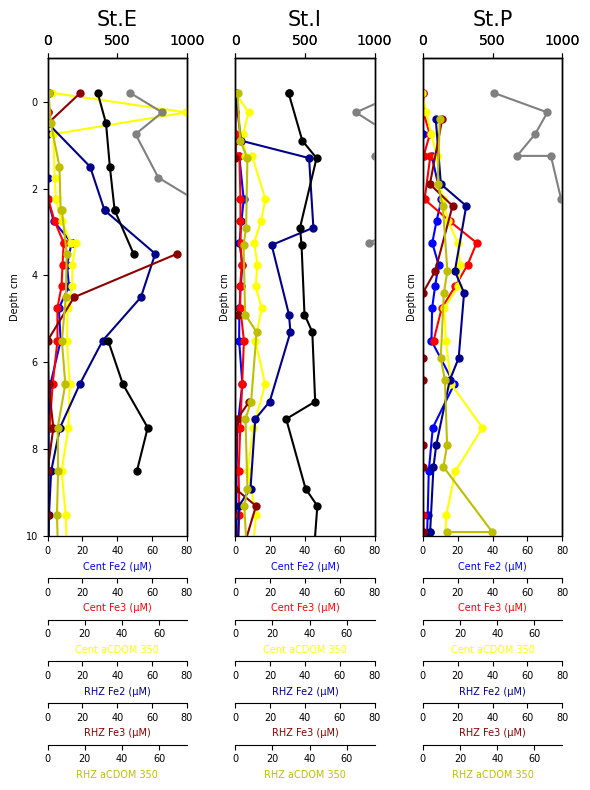

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(6, 8))

stns = df['Location'].unique()

for i, stn in enumerate(stns):
    ax = axes[i]

    ds = df[df['Location']  == stns[i]]

    dsc = ds[ds['Type'] == 'Cent']
    dsr = ds[ds['Type'] == 'Rhz']

    fe2_uM_pw = dsc['Fe2_uM'] 
    fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
    fe3_uM_pw = dsc['Fe3_uM'] 
    fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
    cdom_pw = dsc['acdom_350_bc'] 
    cdom_pw = np.asarray(cdom_pw, dtype=float).ravel()
    doc_pw = dsc['NPOC_uM'] 
    doc_pw = np.asarray(doc_pw, dtype=float).ravel()
    depth_pw = dsc['Depth_CM'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    fe2_uM_rz = dsr['Fe2_uM']
    fe2_uM_rz = np.asarray(fe2_uM_rz, dtype=float).ravel()
    fe3_uM_rz = dsr['Fe3_uM']
    fe3_uM_rz = np.asarray(fe3_uM_rz, dtype=float).ravel()
    cdom_rz = dsr['acdom_350_bc']
    cdom_rz = np.asarray(cdom_rz, dtype=float).ravel()
    doc_rz = dsr['NPOC_uM']
    doc_rz = np.asarray(doc_rz, dtype=float).ravel()
    depth_rz = dsr['Depth_CM']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    ax.plot(fe2_uM_pw, depth_pw, c = 'b', lw = 1.5,  marker = 'o', markersize = 5)
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(10, -1)
    ax.set_xlim(0, 80)

    ax1 = ax.twiny()
    ax1.plot(fe3_uM_pw, depth_pw, c = 'r', lw = 1.5,  marker = 'o', markersize = 5)
    ax1.set_xlim(0, 80)

    ax2 = ax.twiny()
    ax2.plot(cdom_pw, depth_pw, c = 'yellow', lw = 1.5,  marker = 'o', markersize = 5)
    ax2.set_xlim(0, 75)

    ax3 = ax.twiny()
    ax3.plot(fe2_uM_rz, depth_rz, c = 'darkblue', lw = 1.5,  marker = 'o', markersize = 5)
    ax3.set_xlim(0, 80)

    ax4 = ax.twiny()
    ax4.plot(fe3_uM_rz, depth_rz, c = 'darkred', lw = 1.5,  marker = 'o', markersize = 5)
    ax4.set_xlim(0, 80)
    
    ax5 = ax.twiny()
    ax5.plot(cdom_rz, depth_rz, c = 'y', lw = 1.5,  marker = 'o', markersize = 5)
    ax5.set_xlim(0, 75)

    ax6 = ax.twiny()
    ax6.plot(doc_rz, depth_rz, c = 'black', lw = 1.5,  marker = 'o', markersize = 5)
    ax6.set_xlim(0, 1000)

    ax7 = ax.twiny()
    ax7.plot(doc_pw, depth_pw, c = 'grey', lw = 1.5,  marker = 'o', markersize = 5)
    ax7.set_xlim(0, 1000)

    if i == 0:
        axes[i].set_ylabel('Depth cm', size=7, c='black')
        axes[i].yaxis.set_tick_params(labelsize=7)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])


    s = 7

    ax.set_ylabel('Depth cm', size=s, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel('Cent Fe2 (\u03BCM)', size=s, c='b')
    ax.xaxis.set_tick_params(labelsize=s)
            
    ax1.set_xlabel('Cent Fe3 (\u03BCM)', size = s, c= 'r')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 30))
    ax1.xaxis.set_tick_params(labelsize=s)

            
    ax2.set_xlabel('Cent aCDOM 350', size = s, c= 'yellow')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 60))
    ax2.xaxis.set_tick_params(labelsize=s)

    ax3.set_xlabel('RHZ Fe2 (\u03BCM)', size = s, c= 'darkblue')
    ax3.xaxis.set_ticks_position('bottom')
    ax3.xaxis.set_label_position('bottom')
    ax3.spines['bottom'].set_position(('outward', 90))
    ax3.xaxis.set_tick_params(labelsize=s)
            
    ax4.set_xlabel('RHZ Fe3 (\u03BCM)', size = s, c= 'darkred')
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 120))
    ax4.xaxis.set_tick_params(labelsize=s)

    ax5.set_xlabel('RHZ aCDOM 350', size = s, c= 'y')
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 150))
    ax5.xaxis.set_tick_params(labelsize=s)

plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/East_coast_cent_vs_rhz.png')
plt.show()

                         

In [8]:
stop

NameError: name 'stop' is not defined

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(5, 7))

stns = df['Location'].unique()

for i, stn in enumerate(stns):
    ax = axes[i]

    ds = df[df['Location']  == stns[i]]

    dsc = ds[ds['Type'] == 'Cent']
    dsr = ds[ds['Type'] == 'Rhz']

    fe2_uM_pw = dsc['Fe2_uM'] 
    fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
    fe3_uM_pw = dsc['Fe3_uM'] 
    fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
    cdom_pw = dsc['acdom_350_bc'] 
    cdom_pw = np.asarray(cdom_pw, dtype=float).ravel()
    depth_pw = dsc['Depth_CM'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    fe2_uM_rz = dsr['Fe2_uM']
    fe2_uM_rz = np.asarray(fe2_uM_rz, dtype=float).ravel()
    fe3_uM_rz = dsr['Fe3_uM']
    fe3_uM_rz = np.asarray(fe3_uM_rz, dtype=float).ravel()
    cdom_rz = dsr['acdom_350_bc']
    cdom_rz = np.asarray(cdom_rz, dtype=float).ravel()
    depth_rz = dsr['Depth_CM']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    ax.plot(fe2_uM_rz, depth_rz, c = 'darkblue', lw = 1.5)
    ax.set_ylim(15, -1)
    ax.set_xlim(0, 80)

    ax4 = ax.twiny()
    ax4.plot(fe3_uM_rz, depth_rz, c = 'darkred', lw = 1.5)
    ax4.set_ylim(15, -1)
    ax4.set_xlim(0, 80)
    
    ax5 = ax.twiny()
    ax5.plot(cdom_rz, depth_rz, c = 'black', lw = 1.5)
    ax5.set_ylim(15, -1)
    ax5.set_xlim(0, 75)

    if i == 0:
        axes[i].set_ylabel('Depth cm', size=7, c='black')
        axes[i].yaxis.set_tick_params(labelsize=7)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])


    s = 7

    ax.set_ylabel('Depth cm', size=s, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel('RHZ Fe2 (\u03BCM)', size=s, c='darkblue')
    ax.xaxis.set_tick_params(labelsize=s)
                  
    ax4.set_xlabel('RHZ Fe3 (\u03BCM)', size = s, c= 'darkred')
    ax4.xaxis.set_ticks_position('bottom')
    ax4.xaxis.set_label_position('bottom')
    ax4.spines['bottom'].set_position(('outward', 30))
    ax4.xaxis.set_tick_params(labelsize=s)

    ax5.set_xlabel('RHZ aCDOM 350', size = s, c= 'black')
    ax5.xaxis.set_ticks_position('bottom')
    ax5.xaxis.set_label_position('bottom')
    ax5.spines['bottom'].set_position(('outward', 60))
    ax5.xaxis.set_tick_params(labelsize=s)


plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/profile_violin_OM_DOC.png')
plt.show()

                         

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(5, 7))

stns = df['Location'].unique()

for i, stn in enumerate(stns):
    ax = axes[i]

    ds = df[df['Location']  == stns[i]]

    dsc = ds[ds['Type'] == 'Cent']
    dsr = ds[ds['Type'] == 'Rhz']

    fe2_uM_pw = dsc['Fe2_uM'] 
    fe2_uM_pw = np.asarray(fe2_uM_pw, dtype=float).ravel()
    fe3_uM_pw = dsc['Fe3_uM'] 
    fe3_uM_pw = np.asarray(fe3_uM_pw, dtype=float).ravel()
    cdom_pw = dsc['acdom_350_bc'] 
    cdom_pw = np.asarray(cdom_pw, dtype=float).ravel()
    depth_pw = dsc['Depth_CM'] #X var 
    depth_pw = np.asarray(depth_pw, dtype=float).ravel()

    fe2_uM_rz = dsr['Fe2_uM']
    fe2_uM_rz = np.asarray(fe2_uM_rz, dtype=float).ravel()
    fe3_uM_rz = dsr['Fe3_uM']
    fe3_uM_rz = np.asarray(fe3_uM_rz, dtype=float).ravel()
    cdom_rz = dsr['acdom_350_bc']
    cdom_rz = np.asarray(cdom_rz, dtype=float).ravel()
    depth_rz = dsr['Depth_CM']  # X variable
    depth_rz = np.asarray(depth_rz, dtype=float).ravel()

    ax.plot(fe2_uM_pw, depth_pw, c = 'b', lw = 1.5)
    ax.set_title(f'{stn}', size=15)
    ax.set_ylim(15, -1)
    ax.set_xlim(0, 31)

    ax1 = ax.twiny()
    ax1.plot(fe3_uM_pw, depth_pw, c = 'r', lw = 1.5)
    ax1.set_ylim(15, -1)
    ax1.set_xlim(0, 31)

    ax2 = ax.twiny()
    ax2.plot(cdom_pw, depth_pw, c = 'grey', lw = 1.5)
    ax2.set_ylim(15, -1)
    ax2.set_xlim(0, 75)


    if i == 0:
        axes[i].set_ylabel('Depth cm', size=7, c='black')
        axes[i].yaxis.set_tick_params(labelsize=7)
    else: 
        ax.set_ylabel('')
        ax.yaxis.set_ticklabels([])
        ax.set_yticks([])


    s = 7

    ax.set_ylabel('Depth cm', size=s, c='black')
    ax.yaxis.set_tick_params(labelsize=s)

    ax.set_xlabel('Cent Fe2 (\u03BCM)', size=s, c='b')
    ax.xaxis.set_tick_params(labelsize=s)
            
    ax1.set_xlabel('Cent Fe3 (\u03BCM)', size = s, c= 'r')
    ax1.xaxis.set_ticks_position('bottom')
    ax1.xaxis.set_label_position('bottom')
    ax1.spines['bottom'].set_position(('outward', 30))
    ax1.xaxis.set_tick_params(labelsize=s)

            
    ax2.set_xlabel('Cent aCDOM 350', size = s, c= 'grey')
    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 60))
    ax2.xaxis.set_tick_params(labelsize=s)


plt.tight_layout()
fig.set_facecolor('w')
#plt.savefig(f'../Dissertation_projects/Figures/Pore_water_profiles/profile_violin_OM_DOC.png')
plt.show()

                         